# Train-Val-Test Split: Egg Sex Prediction
Run the following code to evaluate single channel models with choice of provided preprocessing. 
The code will split the data into train, validation, and test sets, train the model on the train set, and evaluate the model on the validation and test sets.

Visualizations including trianing history and confusion matrix are provided. 

## Imports/Installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install torcheval
!pip install torchmetrics
!pip install medpy

In [ ]:
import random
import pickle
from PIL import Image
from PIL import ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from collections import defaultdict

import timm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from torcheval.metrics import BinaryAccuracy
from torchmetrics import AUROC
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

## Image Preprocessing



In [ ]:
def clahe_enhance(img):
    '''
    Image Contrast Enhancement Using CLAHE
    '''
    img = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(12,12))
    img = clahe.apply(img)
    return Image.fromarray(img)

def unsharped_mask(img, strength=0.95):
    '''
    Image Sharpening Using Unsharp Mask
    '''
    blurred = img.filter(ImageFilter.GaussianBlur(radius=3.0))  # Apply Gaussian blur
    img_np = np.array(img, dtype=np.float32)
    blurred_np = np.array(blurred, dtype=np.float32) 

    # Apply the unsharp mask formula
    sharpened_np = img_np + strength * (img_np - blurred_np)
    sharpened_np = np.clip(sharpened_np, 0, 255).astype(np.uint8)  # Clip and convert to uint8

    # Convert back to a PIL image
    return Image.fromarray(sharpened_np)

def scharr_edge_detection(img):
    '''
    Image Edge Detection Using Scharr Operator
    '''
    img = np.array(img)
    grad_x = cv2.Scharr(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Scharr(img, cv2.CV_64F, 0, 1)
    edges = cv2.magnitude(grad_x, grad_y)
    return Image.fromarray(np.uint8(edges))

def zoom_image(image):
    '''
    Zoom into an image using a fixed radius around the brightest consecutive 10x10 area.
    '''
    crop_size = 95  # Adjust the zoom level (smaller size = more zoom)
    window_size = 10  # Size of the brightest area to find (10x10)

    img = np.array(image)

    # Calculate the sum of intensities in each 10x10 window
    convolved = np.array([
        np.sum(img[i:i + window_size, j:j + window_size])
        for i in range(img.shape[0] - window_size + 1)
        for j in range(img.shape[1] - window_size + 1)
    ]).reshape(img.shape[0] - window_size + 1, img.shape[1] - window_size + 1)

    # Find the brightest window
    max_sum_coords = np.unravel_index(np.argmax(convolved, axis=None), convolved.shape)

    x_center = max_sum_coords[0] + window_size // 2
    y_center = max_sum_coords[1] + window_size // 2

    # Calculate cropping boundaries
    x_min = max(0, x_center - crop_size)
    x_max = min(img.shape[0], x_center + crop_size)
    y_min = max(0, y_center - crop_size)
    y_max = min(img.shape[1], y_center + crop_size)

    cropped_image = img[x_min:x_max, y_min:y_max]
    return Image.fromarray(cropped_image).resize(image.size, Image.LANCZOS)


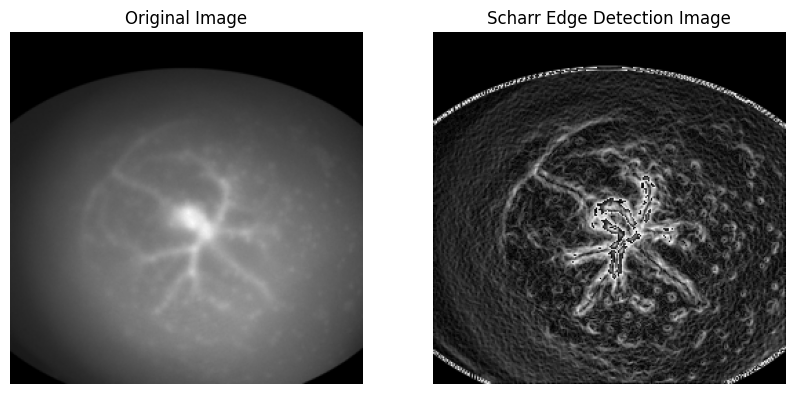

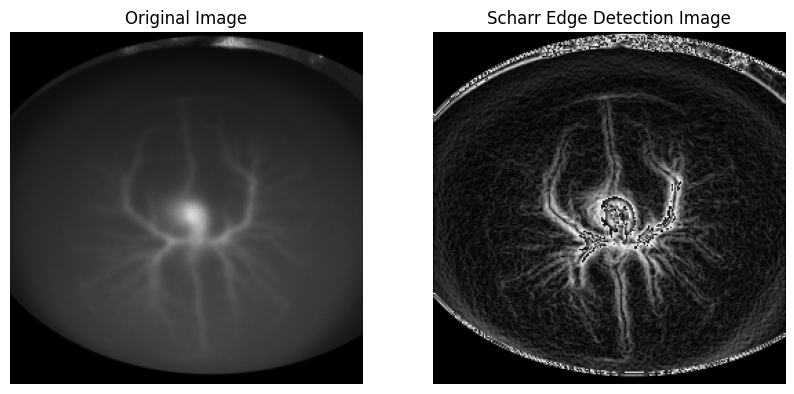

In [ ]:
def normalize_individual_image(image):
    '''
    Calculate the mean and standard deviation of an image tensor.
    '''
    mean = image.mean()
    std = image.std()
    return transforms.Normalize(mean=[mean], std=[std])(image), mean, std

def load_from_pickle_and_visualize(pickle_file_path, num_images = 5):
    '''
    Load a pickle file and visualize a specified number of images, including their
    original and preprocessed versions.
    '''

    # Load the pickle file
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)

    # Assuming data is a list or dictionary of images
    random_indices = random.sample(range(len(data)), num_images)
    for idx in random_indices:
        data_point = data[idx]
        image = data_point['image']

        # Convert image to PIL format (if it's not already)
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Convert to tensor and preprocess
        transform_pipeline = transforms.Compose([
            transforms.Lambda(lambda x: scharr_edge_detection(x)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ])

        # Convert to tensor and preprocess
        transform_normal = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ])

        image_tensor = transform_pipeline(image)
        image_normal = transform_normal(image)

        _, mean, std = normalize_individual_image(image_tensor)

        def visualize_images(original, normalized, mean, std):
          '''
          Visualize the original and normalized images.
          '''
          _, axes = plt.subplots(1, 2, figsize=(10, 5))

          # Original image
          axes[0].imshow(np.transpose(original.numpy(), (1, 2, 0)))
          axes[0].set_title("Original Image")
          axes[0].axis('off')

          # Preprocessed image
          axes[1].imshow(np.transpose(normalized.numpy(), (1, 2, 0)))
          axes[1].set_title("Scharr Edge Detection Image")
          axes[1].axis('off')

          plt.show()

        # Visualize the original and normalized images
        visualize_images(image_normal, image_tensor, mean, std)

load_from_pickle_and_visualize('/content/drive/MyDrive/CS 163/egg_sex_zoomed/HH19_256/training/training_256_part_1.pickle', num_images = 2)

## Creating Dataloaders and Loading Model

In [ ]:
def create_grayscale_model(model_name, img_dim = 1, pretrained=True, num_classes=1, device=None, features_only=False):
    '''
    Loading a pretrained model and changing the first convolutional layer to accept img_dim channel images.
    Supports ResnetBiT, ResNet152, Xception, EfficientNet, Densenet121, InceptionV3, VGG19, and MobileNetV3.
    '''

    print("Loading model:", model_name)
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, features_only=features_only)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    first_conv_layer = None

    # Find the first layer of the model, different cases for different model architectures
    if hasattr(model, 'stem'):
        for layer in model.stem.modules():
            if isinstance(layer, nn.Conv2d) and layer.in_channels == 3:
                first_conv_layer = layer
                break
    elif hasattr(model, 'conv1'):
        first_conv_layer = model.conv1
    elif hasattr(model, 'features') and isinstance(model.features, nn.Sequential):
        for layer in model.features:
            if isinstance(layer, nn.Conv2d) and layer.in_channels == 3:
                first_conv_layer = layer
                break
    elif hasattr(model, 'Conv2d_1a_3x3'):
        first_conv_layer = model.Conv2d_1a_3x3.conv
    elif hasattr(model, 'conv_stem'):
        first_conv_layer = model.conv_stem
    elif hasattr(model, 'stem_conv'):
        first_conv_layer = model.stem_conv

    if first_conv_layer is not None:
        # Create a new Conv2d layer by changing the in_channels size
        new_first_conv = nn.Conv2d(
            in_channels=img_dim,
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=first_conv_layer.bias is not None
        )

        # Copy pretrained weights by averaging over the RGB channels
        with torch.no_grad():
            new_first_conv.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)

        # Replace the first convolutional layer with the new compatible layer
        first_conv_layer.in_channels = img_dim
        first_conv_layer.weight = new_first_conv.weight
        if first_conv_layer.bias is not None:
            first_conv_layer.bias = new_first_conv.bias

    else:
        raise ValueError(f"No suitable first convolutional layer found for model {model_name}.")

    return model

## Creating Dataloaders

In [ ]:
# Hyperparameters
num_classes = 1
lr = 0.0001
n_epochs = 100
batch_size = 64
batch_size_test = 64
RANDOM_SEED = 1839
pretrained = True

# Pretrained Models
densenet_model = 'densenet121.tv_in1k'
resnet_model = 'resnet152.tv2_in1k'
resnetbit_model = 'resnetv2_50x1_bit.goog_in21k'
inception_model = 'inception_v3.tv_in1k'
vgg_model = 'vgg19.tv_in1k'
xception_model = 'xception41.tf_in1k'
maxvit_model = 'maxvit_nano_rw_256.sw_in1k'
mobilenet_model = 'mobilenetv3_large_100.ra_in1k'
efficientnet_model = 'efficientnet_b0.ra_in1k'
convnext_model = 'convnext_tiny.fb_in22k'

# Set path to loaded data
dataset_path = "/content/drive/MyDrive/CS 163/egg_sex_zoomed/full_256"
train_set_path = os.path.join(dataset_path, 'training')
test_set_path = os.path.join(dataset_path, 'testing')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    '''
    Dataset class for loading data from pickle files.
    '''
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.ids = []

        self.transform_normal = transforms.Compose([
            transforms.Lambda(lambda x:unsharped_mask(x)),
            # transforms.Lambda(lambda x:scharr_edge_detection(x)),
            # transforms.Lambda(lambda x: clahe_enhance(x)),
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                raw_data = pickle.load(f)
                self.data.extend(raw_data)

        for data_point in self.data:
            self.ids.append(data_point['additional_info']['id'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']

        if self.transform_normal:
          image_normal = self.transform_normal(image)

        # Normalize to [0, 1] for consistency
        np_image = np.array(image_normal).astype(np.float32) / 255.0

        mean = np_image.mean(axis=(0, 1), keepdims=True)
        std = np_image.std(axis=(0, 1), keepdims=True)
        np_image = (np_image - mean) / (std + 1e-8)  # Add epsilon to avoid division by zero

        # Normalize by imagenet mean and std
        imagenet_mean = np.array([0.449])
        imagenet_std = np.array([0.226])
        np_image = (np_image - imagenet_mean) / imagenet_std

        # For 1-channel image
        image_tensor = torch.tensor(np_image).unsqueeze(0).float()

        label = torch.tensor(int(data_point['label']), dtype=torch.float32)
        additional_info = data_point['additional_info']

        return image_tensor, label, additional_info

class SubsetDataset(Dataset):
    '''
    Dataset class for organizing data into training and validation sets,
    with different augmentation only for the training set.
    '''
    def __init__(self, data, is_val = False):
        self.data = data
        self.ids = []

        self.transform_normal = transforms.Compose([
            transforms.Lambda(lambda x:unsharped_mask(x)),
            # transforms.Lambda(lambda x:scharr_edge_detection(x)),
            # transforms.Lambda(lambda x: clahe_enhance(x)),
        ])

        self.transform_augment = transforms.Compose([])

        if not is_val:
          self.transform_augment = transforms.Compose([
              transforms.RandomAffine(
                  degrees=180,
                  translate=(0.05, 0.05),
                  scale=(0.95, 1.05),
                  fill=0
              ),
              transforms.RandomHorizontalFlip(p=0.3),
              transforms.RandomVerticalFlip(p=0.3),
          ])

        for data_point in self.data:
            self.ids.append(data_point['additional_info']['id'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']

        if self.transform_normal:
            image_normal = self.transform_normal(image)

        # Normalize to [0, 1] for consistency
        np_image = np.array(image_normal).astype(np.float32) / 255.0

        # If augmentation is defined, ensure compatibility with the transform
        if self.transform_augment:
            np_image_uint8 = (np_image * 255).astype(np.uint8)  # Convert back to [0, 255] as uint8
            pil_image = Image.fromarray(np_image_uint8)  # Convert NumPy array to PIL Image
            augmented_image = self.transform_augment(pil_image)
            np_image = np.array(augmented_image).astype(np.float32) / 255.0  # Convert back to NumPy and normalize

        # Normalize to zero mean and unit variance
        mean = np_image.mean(axis=(0, 1), keepdims=True)
        std = np_image.std(axis=(0, 1), keepdims=True)
        np_image = (np_image - mean) / (std + 1e-8)  # Add epsilon to avoid division by zero

        # Further normalization using ImageNet mean and std
        imagenet_mean = np.array([0.449])
        imagenet_std = np.array([0.226])
        np_image = (np_image - imagenet_mean) / imagenet_std

        # For 1-channel image
        image_tensor = torch.tensor(np_image).unsqueeze(0).float()

        label = torch.tensor(int(data_point['label']), dtype=torch.float32)
        additional_info = data_point['additional_info']

        return image_tensor, label, additional_info

def set_seed(RANDOM_SEED):
    '''
    Set random seed for reproducibility.
    '''
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.bexnchmark = False
    torch.backends.cudnn.deterministic = True

def split_dataset(dataset, test_size=0.1, random_seed=42):
    '''
    Given a dataset, split it into training and validation sets
    to ensure that images of the same egg id are not in both sets.
    '''
    ids = [data_point['additional_info']['id'] for data_point in dataset.data]
    unique_ids = list(set(ids))

    train_ids, val_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_seed)

    train_data = [data_point for data_point in dataset.data if data_point['additional_info']['id'] in train_ids]
    val_data = [data_point for data_point in dataset.data if data_point['additional_info']['id'] in val_ids]

    return train_data, val_data

set_seed(RANDOM_SEED)

models = [create_grayscale_model(model, img_dim=1, pretrained=pretrained, num_classes=num_classes).to(device)
            for model in [resnetbit_model]]
model_names = ['ResnetBiT']

dataset_full = CustomDataset(train_set_path)
dataset_test = CustomDataset(test_set_path)
train_data, val_data = split_dataset(dataset_full, test_size=0.10)
dataset_train = SubsetDataset(train_data)
dataset_validation = SubsetDataset(val_data, is_val = True)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size_test, shuffle=False, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, drop_last=False)

num_samples_train = len(dataloader_train.dataset)
num_samples_test = len(dataloader_test.dataset)
num_samples_val = len(dataloader_validation.dataset)
print(f"Training Set Size = {num_samples_train} images")
print(f"Validation Set Size = {num_samples_val} images")
print(f"Test Set Size = {num_samples_test} images")
print("Loaded all dataloaders successfully")

Loading model: resnetv2_50x1_bit.goog_in21k


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

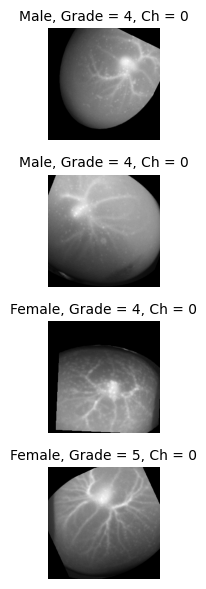

In [ ]:
def visualize_samples(dataloader, num_images=4, save_path="egg_embryo_examples.png"):
    '''
    Visualize all channels from specified number of images from a dataloader.
    '''
    images, labels, additional_info = next(iter(dataloader))

    # Select male and female images
    male_images = [(img, grade) for img, label, grade in zip(images, labels, additional_info["grade"]) if label == 0]
    female_images = [(img, grade) for img, label, grade in zip(images, labels, additional_info["grade"]) if label == 1]

    num_per_gender = num_images // 2
    male_images = male_images[:num_per_gender]
    female_images = female_images[:num_per_gender]

    # Prepare figure size based on the number of channels and images
    num_channels = images.shape[1]  # Number of channels
    plt.figure(figsize=(12, 3 * num_channels * num_images // 2))

    # Helper function to plot individual images
    def plot_image(ax, image, channel, title):
        img = image[channel].numpy()  # Extract specific channel
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        ax.imshow(img, cmap="gray")
        ax.set_title(title, size=10)
        ax.axis("off")

    # Display male images with their channels
    for i, (image, grade) in enumerate(male_images):
        for c in range(num_channels):
            ax = plt.subplot(2 * num_per_gender, num_channels, i * num_channels + c + 1)
            plot_image(ax, image, c, f"Male, Grade = {grade}, Ch = {c}")

    # Display female images with their channels
    for i, (image, grade) in enumerate(female_images):
        for c in range(num_channels):
            ax = plt.subplot(2 * num_per_gender, num_channels, (num_per_gender + i) * num_channels + c + 1)
            plot_image(ax, image, c, f"Female, Grade = {grade}, Ch = {c}")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

visualize_samples(dataloader_train)


# Model Training

In [ ]:
def train(dataloader_train, model, loss_fn, optimizer, device):
    '''
    Standard training loop for a single epoch.
    '''
    model.train()

    running_loss = 0.0
    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task = 'binary')  # For binary classification AUC

    for batch_id, (images, labels, additional_info) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        accuracy_metric.update(predictions, labels)
        auc_metric.update(predictions, labels)

    loss_of_epoch = running_loss / len(dataloader_train)
    accuracy = accuracy_metric.compute().item()  # Compute accuracy after all batches
    auc_score = auc_metric.compute().item()  # Compute AUC after all batches

    print(f'Train Loss: {loss_of_epoch:.4f} \t Train Accuracy: {accuracy:.2f} \t Train AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score

def train_altered(dataloader_train, model, loss_fn, optimizer, device):
    '''
    Altered training loop for a single epoch.
    AUC and Acc are computed per egg ID. An egg id with n images will have 1 prediction and label.
    '''
    model.train()

    running_loss = 0.0

    # Store aggregated predictions and labels per ID
    predictions_per_id = defaultdict(list)
    labels_per_id = defaultdict(list)

    for batch_id, (images, labels, additional_info) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(images).sigmoid().squeeze(1)  # Ensure output is a probability-like
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Aggregate predictions and labels by ID
        ids = additional_info['id']
        for i, id_ in enumerate(ids):
            predictions_per_id[id_.item()].append(predictions[i].item())
            labels_per_id[id_.item()].append(labels[i].item())

    aggregated_predictions = []
    aggregated_labels = []

    for id_ in predictions_per_id.keys():
        pred_list = predictions_per_id[id_]
        label_list = labels_per_id[id_]

        # Check if the number of images for this ID is even or odd
        if len(pred_list) % 2 == 0:
            # Use mean when the number of images is even
            aggregated_predictions.append(np.mean(pred_list))
        else:
            # Use majority voting when the number of images is odd
            majority_vote = int(np.mean(np.round(pred_list)) > 0.5)  # Round predictions and check majority
            aggregated_predictions.append(majority_vote)

        aggregated_labels.append(np.mean(label_list))

    # Convert to tensors for metric computations
    assert len(aggregated_predictions) == len(aggregated_labels)
    assert len(aggregated_predictions) < 1000
    print(f'Calculating over {len(aggregated_predictions)} eggs.')
    aggregated_predictions = torch.tensor(aggregated_predictions, device=device)
    aggregated_labels = torch.tensor(aggregated_labels, device=device)

    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task='binary')

    accuracy_metric.update(aggregated_predictions, aggregated_labels)
    auc_metric.update(aggregated_predictions, aggregated_labels)

    accuracy = accuracy_metric.compute().item()
    auc_score = auc_metric.compute().item()

    loss_of_epoch = running_loss / len(dataloader_train)

    print(f'Train Loss: {loss_of_epoch:.4f} \t Train Accuracy: {accuracy:.2f} \t Train AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score

def validate(dataloader_test, model, loss_fn, device):
    '''
    Standard validation loop for a single epoch.
    '''
    model.eval()

    running_loss = 0.0
    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task='binary')  # For binary classification AUC

    with torch.no_grad():
        for batch_id, (images, labels, additional_info) in enumerate(dataloader_test):
            images, labels = images.to(device), labels.to(device)
            # print(additional_info)

            predictions = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
            loss = loss_fn(predictions, labels)

            running_loss += loss.item()

            accuracy_metric.update(predictions, labels)
            auc_metric.update(predictions, labels)

    loss_of_epoch = running_loss / len(dataloader_test)
    accuracy = accuracy_metric.compute().item()
    auc_score = auc_metric.compute().item()  # Compute AUC after all batches

    print(f'Test Loss: {loss_of_epoch:.4f} \t Test Accuracy: {accuracy:.3f} \t Test AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score

def validate_altered(dataloader_val, model, loss_fn, device):
    '''
    Altered validation loop for a single epoch.
    AUC and Acc are computed per egg ID. An egg id with n images will have 1 prediction and label.
    '''

    model.eval()

    running_loss = 0.0

    # Store aggregated predictions and labels per ID
    predictions_per_id = defaultdict(list)
    labels_per_id = defaultdict(list)

    with torch.no_grad():
      for batch_id, (images, labels, additional_info) in enumerate(dataloader_val):
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          predictions = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
          loss = loss_fn(predictions, labels)

          running_loss += loss.item()

          # Aggregate predictions and labels by ID
          ids = additional_info['id']
          for i, id_ in enumerate(ids):
              predictions_per_id[id_.item()].append(predictions[i].item())
              labels_per_id[id_.item()].append(labels[i].item())

    aggregated_predictions = []
    aggregated_labels = []

    for id_ in predictions_per_id.keys():
        pred_list = predictions_per_id[id_]
        label_list = labels_per_id[id_]

        # Check if the number of images for this ID is even or odd
        if len(pred_list) % 2 == 0:
            # Use mean when the number of images is even
            aggregated_predictions.append(np.mean(pred_list))
        else:
            # Use majority voting when the number of images is odd
            majority_vote = int(np.mean(np.round(pred_list)) > 0.5)  # Round predictions and check majority
            aggregated_predictions.append(majority_vote)

        aggregated_labels.append(np.mean(label_list))

    # Convert to tensors for metric computations
    assert len(aggregated_predictions) == len(aggregated_labels)
    assert len(aggregated_predictions) < 500
    print(f'Calculating over {len(aggregated_predictions)} eggs.')
    aggregated_predictions = torch.tensor(aggregated_predictions, device=device)
    aggregated_labels = torch.tensor(aggregated_labels, device=device)

    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task='binary')

    accuracy_metric.update(aggregated_predictions, aggregated_labels)
    auc_metric.update(aggregated_predictions, aggregated_labels)

    accuracy = accuracy_metric.compute().item()
    auc_score = auc_metric.compute().item()

    loss_of_epoch = running_loss / len(dataloader_val)

    print(f'Val Loss: {loss_of_epoch:.4f} \t Val Accuracy: {accuracy:.2f} \t Val AUC: {auc_score:.4f}')

    return loss_of_epoch, accuracy, auc_score

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01, path='checkpoint.pth', monitor='accuracy'):
        '''
        Args:
            patience (int): How long to wait after the last improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): File path to save the best model.
            monitor (str): Metric to monitor ('accuracy' or 'auc').
        '''
        self.patience = patience
        self.delta = delta
        self.path = path
        self.monitor = monitor
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, metric, model):
        # Update logic for max-imization (accuracy or AUC)
        if self.best_score is None:
            self.best_score = metric
            self.save_checkpoint(model)
        elif metric < self.best_score + self.delta:  # No improvement within delta
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:  # Improvement
            self.best_score = metric
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
train_loss_all, train_acc_all, train_auc_all = list(), list(), list()
val_loss_all, val_acc_all, val_auc_all = list(), list(), list()
test_loss_all, test_acc_all, test_auc_all = list(), list(), list()

trained_models = []

for i, training_model in enumerate(models):
    print(f'MODEL {model_names[i]}')
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(training_model.parameters(), betas=(0.9, 0.999), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    print("Starting training...")

    train_loss_all.append(list())
    train_acc_all.append(list())
    train_auc_all.append(list())
    val_loss_all.append(list())
    val_acc_all.append(list())
    val_auc_all.append(list())
    test_loss_all.append(list())
    test_acc_all.append(list())
    test_auc_all.append(list())
    early_stopping = EarlyStopping(patience=8, path='best_model.pth', monitor='acc')  # Change to 'auc' if needed

    for epoch in range(n_epochs):
        print(f'\nEpoch {epoch+1}\n{"-"*28}')

        loss_training, accuracy_training, auc_training = train(dataloader_train, training_model, loss_fn, optimizer, device)
        loss_validation, accuracy_validation, auc_validation = validate(dataloader_validation, training_model, loss_fn, device)
        loss_test, accuracy_test, auc_test = validate(dataloader_test, training_model, loss_fn, device)

        train_loss_all[-1].append(loss_training)
        train_acc_all[-1].append(accuracy_training)
        train_auc_all[-1].append(auc_training)

        val_loss_all[-1].append(loss_validation)
        val_acc_all[-1].append(accuracy_validation)
        val_auc_all[-1].append(auc_validation)

        test_loss_all[-1].append(loss_test)
        test_acc_all[-1].append(accuracy_test)
        test_auc_all[-1].append(auc_test)

        scheduler.step()

        if epoch >= 50:
            metric_to_monitor = auc_validation if early_stopping.monitor == 'auc' else accuracy_validation
            early_stopping(metric_to_monitor, training_model)

            if early_stopping.early_stop:
                print(f"Early stopping triggered on {early_stopping.monitor.upper()} at epoch {epoch+1}.")
                break


    if early_stopping.early_stop:
      training_model.load_state_dict(torch.load('best_model.pth'))
      trained_models.append(training_model)
    else:
      trained_models.append(training_model)

## Plotting Training/Validation Curves

Testing Model ResnetBiT on the test set
Test Loss: 0.8880 	 Test Accuracy: 0.572 	 Test AUC: 0.5894


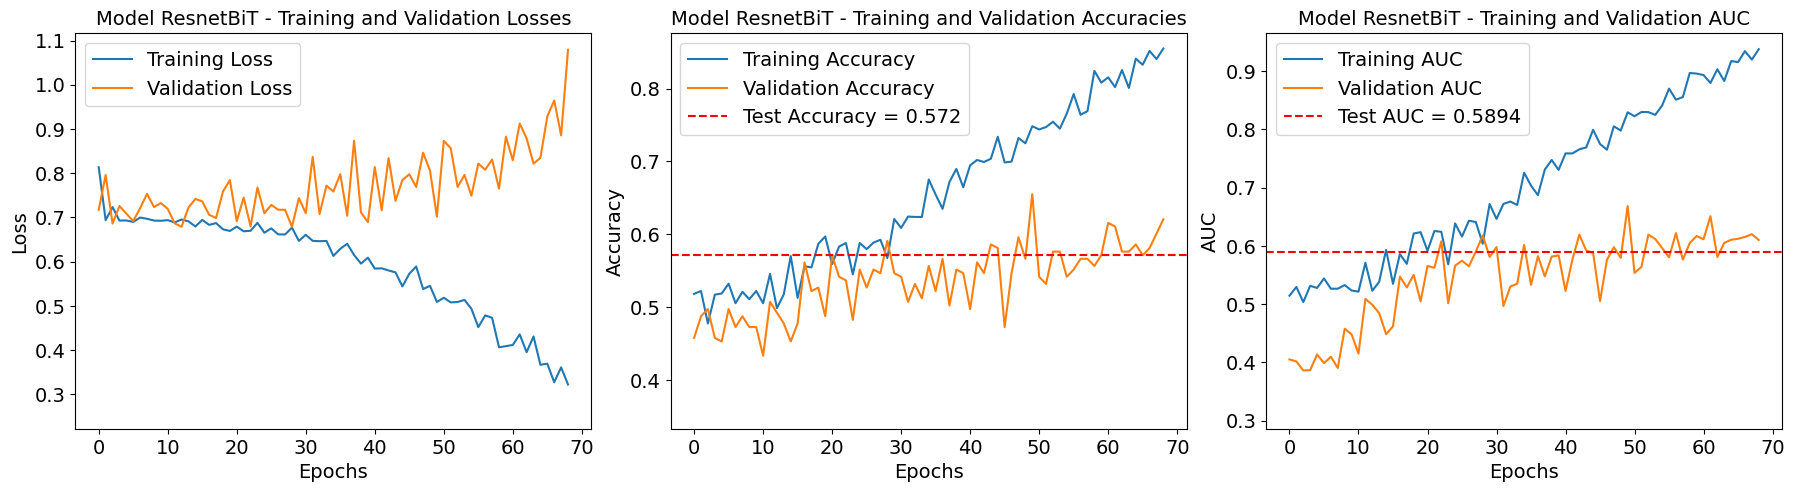

In [ ]:
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

n_models = len(trained_models)
fig, axs = plt.subplots(n_models, 3, figsize=(18, 5 * n_models))

for idx, (train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, train_auc, val_auc, test_auc) in enumerate(
        zip(train_loss_all, val_loss_all, test_loss_all, train_acc_all, val_acc_all, test_acc_all, train_auc_all, val_auc_all, test_auc_all)):

    # Test results for the current model
    print(f"Testing Model {model_names[idx]} on the test set")
    loss_test, accuracy_test, auc_test = validate(dataloader_test, trained_models[idx], loss_fn, device)

    # If only one model, axs won't be 2D, so we convert it to 2D for uniform access
    model_axs = axs if n_models == 1 else axs[idx]

    # Plot for Training and Validation Losses
    model_axs[0].set_title(f"Model {model_names[idx]} - Training and Validation Losses")
    model_axs[0].plot(train_loss, label="Training Loss")
    model_axs[0].plot(val_loss, label="Validation Loss")
    model_axs[0].set_ylim(ymin=min(min(train_loss), min(val_loss)) - 0.1)
    model_axs[0].set_xlabel("Epochs")
    model_axs[0].set_ylabel("Loss")
    model_axs[0].legend()

    # Plot for Accuracies
    model_axs[1].set_title(f"Model {model_names[idx]} - Training and Validation Accuracies")
    model_axs[1].plot(train_acc, label="Training Accuracy")
    model_axs[1].plot(val_acc, label="Validation Accuracy")
    model_axs[1].axhline(y=accuracy_test, color='r', linestyle='--', label=f"Test Accuracy = {round(accuracy_test, 4)}")
    model_axs[1].set_ylim(ymin=min(min(train_acc), min(val_acc)) - 0.1)
    model_axs[1].set_xlabel("Epochs")
    model_axs[1].set_ylabel("Accuracy")
    model_axs[1].legend()

    # Plot for AUC
    model_axs[2].set_title(f"Model {model_names[idx]} - Training and Validation AUC")
    model_axs[2].plot(train_auc, label="Training AUC")
    model_axs[2].plot(val_auc, label="Validation AUC")
    model_axs[2].axhline(y=auc_test, color='r', linestyle='--', label=f"Test AUC = {round(auc_test, 4)}")
    model_axs[2].set_ylim(ymin=min(min(train_auc), min(val_auc)) - 0.1)
    model_axs[2].set_xlabel("Epochs")
    model_axs[2].set_ylabel("AUC")
    model_axs[2].legend()

plt.subplots_adjust(hspace=1.5)

# Adjust layout to prevent overlapping
plt.tight_layout(pad = 1.0)
plt.savefig('1-channel_training_zoomed_256_majority_vote_100_unsharp.png')
plt.show()

In [ ]:
torch.save(trained_models[0].state_dict(), "model.pt")

## Model Performance Visualizations

In [ ]:
def get_conf_matrix(dataloader_test, model, device):
    '''
    Calculate and print the confusion matrix for a given model and dataloader.
    '''
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            predictions = model(images).sigmoid().squeeze(1)
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())

    all_predictions = torch.cat(all_predictions).numpy().round()  # Convert to binary
    all_labels = torch.cat(all_labels).numpy()

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f'Confusion Matrix:\n{conf_matrix}')

    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0 (Male)', 'Class 1 (Female)'], yticklabels=['Class 0 (Male)', 'Class 1 (Female)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def analyze_confidences(dataloader_test, model, device):
    '''
    Plot a histogram of the confidences of the model's correct and incorrect predictions
    for a given dataloader.
    '''
    model.eval()
    confidences_correct = []
    confidences_incorrect = []

    with torch.no_grad():
        for images, labels, _ in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            predictions = model(images).sigmoid().squeeze(1)
            predicted_labels = predictions.round()
            confidences = predictions.cpu().numpy()
            labels = labels.cpu().numpy()

            for i, conf in enumerate(confidences):
                if predicted_labels[i] == labels[i]:
                    confidences_correct.append(conf)
                else:
                    confidences_incorrect.append(conf)

    print(len(confidences_correct), len(confidences_incorrect))
    return confidences_correct, confidences_incorrect

def plot_confidence_distributions(confidences_correct, confidences_incorrect):
    plt.figure(figsize=(10, 6))
    sns.histplot(confidences_correct, color='green', label='Correct Predictions', bins=20, kde = True)
    sns.histplot(confidences_incorrect, color='red', label='Incorrect Predictions', bins=20, kde = True)
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Levels of Predictions')
    plt.legend()
    plt.savefig('confidence_distributions.png')
    plt.show()

In [ ]:
def get_model_outputs(dataloader, model, device):
    """
    Helper function to get confidences, predictions, and labels from a 
    trained model and dataloader.
    """
    model.eval()  # Set the model to evaluation mode
    all_confidences = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels, *_ in dataloader:  # Additional fields can be ignored
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)  # Assuming binary classification

            confidences = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = (confidences >= 0.5).float()  # Threshold for binary predictions

            # Store results
            all_confidences.extend(confidences.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_confidences, all_predictions, all_labels

def plot_accuracy_per_bin(confidences, labels, predicted_labels, num_bins=10):
    '''
    For all of the models raw predictions, plots a histogram of the accuracy per
    predicted probability bin.
    '''
    confidences = np.array(confidences)
    predicted_labels = np.array(predicted_labels)
    labels = np.array(labels)

    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1

    accuracies = []
    avg_confidences = []

    # Calculate accuracy and average confidence for each bin
    for i in range(num_bins):
        bin_confidences = confidences[bin_indices == i]
        bin_labels = labels[bin_indices == i]
        bin_preds = predicted_labels[bin_indices == i]

        if len(bin_confidences) > 0:
            avg_confidences.append(bin_confidences.mean())
            accuracies.append((bin_preds == bin_labels).mean())
        else:
            avg_confidences.append(0)
            accuracies.append(0)

    plt.figure(figsize=(8, 6))
    plt.plot(avg_confidences, accuracies, marker='o')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram: Accuracy vs Probability Bins")
    plt.legend()
    plt.grid()
    plt.show()

def plot_reliability_diagram_with_frequencies(confidences, labels, num_bins=10):
    '''
    This function plots the reliability diagram with positive and negative frequencies.
    '''
    confidences = np.array(confidences)
    labels = np.array(labels)

    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1

    # Calculate the relative frequency of positive and negative samples in each bin
    positive_frequencies = []
    negative_frequencies = []

    for i in range(num_bins):
        # Select the samples that fall into the current bin
        bin_labels = labels[bin_indices == i]

        if len(bin_labels) > 0:
            # Calculate the relative frequency of positive (1) and negative (0) labels
            positive_frequencies.append(np.mean(bin_labels))
            negative_frequencies.append(1 - np.mean(bin_labels))
        else:
            positive_frequencies.append(0)
            negative_frequencies.append(0)

    # Plot the positive frequency diagram
    plt.figure(figsize=(8, 6))
    plt.plot(bins[:-1], positive_frequencies, marker='o', label="Positive Frequency", color='blue')
    plt.plot(bins[:-1], bins[:-1], linestyle='--', label="Perfect Calibration (Positive)", color='green')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Positive Relative Frequency")
    plt.title("Reliability Diagram: Positive Frequency vs Probability Bins")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the negative frequency diagram
    plt.figure(figsize=(8, 6))
    plt.plot(bins[:-1], negative_frequencies, marker='x', label="Negative Frequency", color='red')
    plt.plot(bins[:-1], 1 - bins[:-1], linestyle='--', label="Perfect Calibration (Negative)", color='orange')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Negative Relative Frequency")
    plt.title("Reliability Diagram: Negative Frequency vs Probability Bins")
    plt.legend()
    plt.grid()
    plt.show()

def print_precision_recall(y_true, y_pred):
    """
    Calculate and print precision and recall for each class in a multi-class classification.
    """
    # Get the unique classes
    classes = sorted(set(y_true))

    for cls in classes:
        # For each class, calculate precision and recall
        precision = precision_score(y_true, y_pred, pos_label=cls)
        recall = recall_score(y_true, y_pred, pos_label=cls)

        # Print precision and recall for the current class
        print(f"Class {cls}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("-" * 40)

Class 0.0:
  Precision: 0.6148
  Recall: 0.6180
----------------------------------------
Class 1.0:
  Precision: 0.5727
  Recall: 0.5693
----------------------------------------


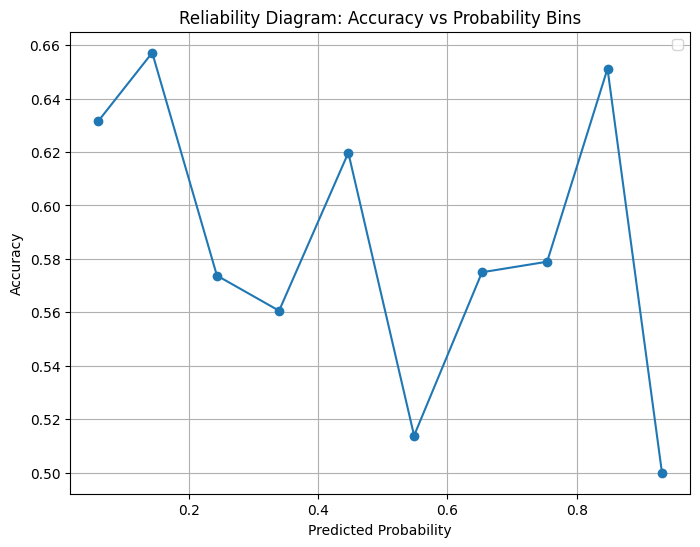

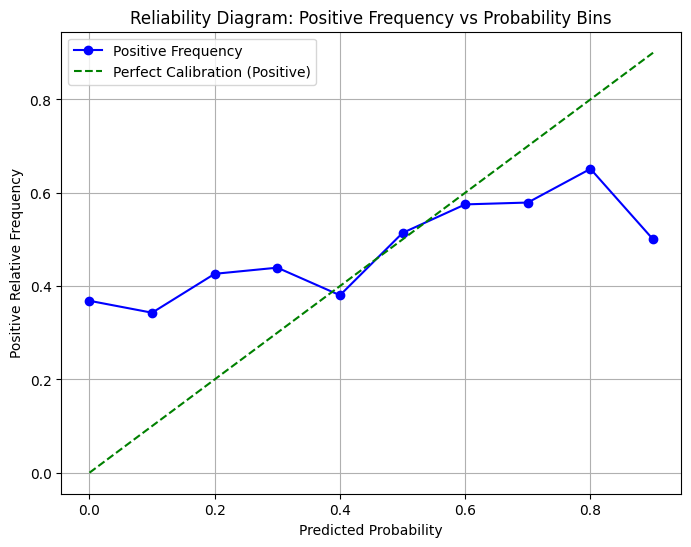

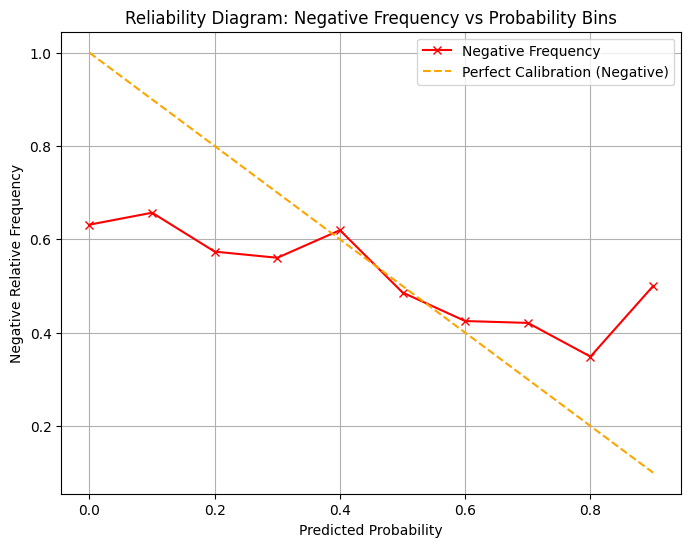

In [ ]:
model = trained_models[-1]
confidences, predictions, labels = get_model_outputs(dataloader_test, model, device)
print_precision_recall(labels, predictions)
plot_accuracy_per_bin(confidences, labels, predictions)
plot_reliability_diagram_with_frequencies(confidences, labels)

Confusion Matrix:
[[233 144]
 [146 193]]


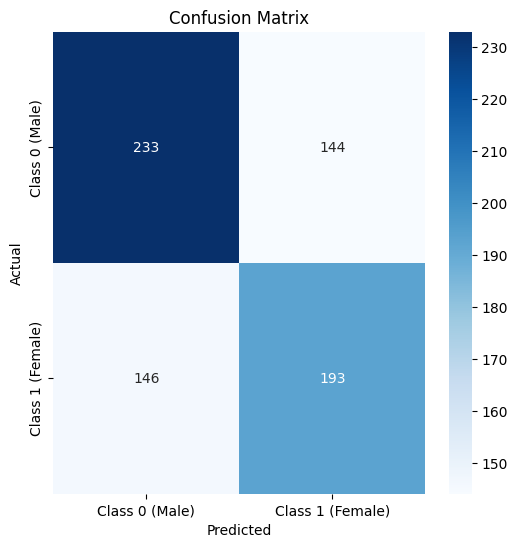

In [ ]:
model = trained_models[-1]
conf_matrix = get_conf_matrix(dataloader_test, model, device)
plot_confusion_matrix(conf_matrix)

426 290


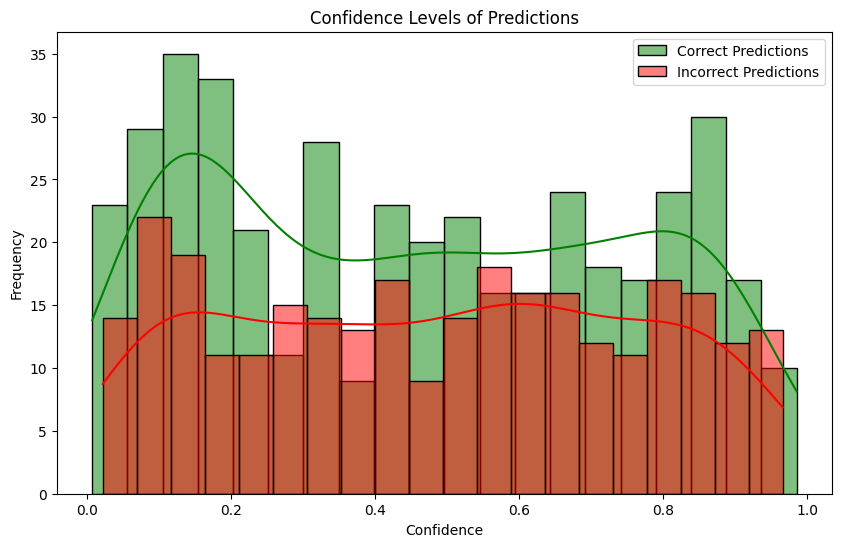

In [ ]:
correct, incorrect = analyze_confidences(dataloader_test, model, device)
plot_confidence_distributions(correct, incorrect)